In [67]:
import os
import cv2
import itertools
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from keras.callbacks import EarlyStopping
from keras import backend as K

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout

import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband

from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import GlobalAveragePooling2D

from tensorflow.python.keras.models import Sequential

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from tensorflow import keras

In [2]:
# funtion to write predictions
def write_preds(preds, fname):
    pd.DataFrame({"id": list(range(1,len(preds)+1)), "label":   preds}).to_csv(fname, index=False)

In [29]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
IMG_DIR = os.path.join('images')

In [32]:
EPOCHS                  = 30
IMGSIZE                 = 128
BATCH_SIZE              = 64
STOPPING_PATIENCE       = 15
VERBOSE                 = 3
OPTIMIZER               = 'adam'

In [109]:
#function prints and plots the confusion matrix.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(20,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## EDA

In [5]:
train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [7]:
train.columns

Index(['id', 'species', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5',
       'margin6', 'margin7', 'margin8',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=194)

In [8]:
print(train.isnull().any().any())
print(test.isnull().any().any())

False
False


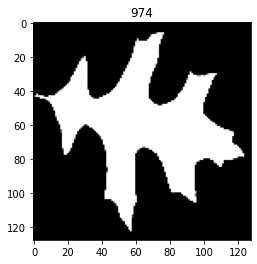

In [33]:
for img in os.listdir(IMG_DIR)[1556:]:
    img_path = os.path.join(IMG_DIR, img)
    img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_arr = cv2.resize(img_arr, (IMGSIZE, IMGSIZE))
    plt.imshow(img_arr, cmap='gray')
    plt.title(img.split('.')[0])
    break

In [10]:
def setBoxplot(ax,ylim):
    ax.set_ylim(ylim);
    ax.tick_params(axis='y',labelsize=6);
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=7);

In [41]:
def correlation_matrix(df,ax1):
    import numpy as np
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    cmap = cm.get_cmap('RdYlBu', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap, vmin=-1.0, vmax=1.0)
    ax1.grid(True)
    labels = df.columns
    ax1.set_xticks(range(0,len(labels)))
    ax1.set_xticklabels(labels,fontsize=7,rotation=90)
    ax1.set_yticks(range(0,len(labels)))
    ax1.set_yticklabels(labels,fontsize=7)
    cbar = fig.colorbar(cax)
    cbar.ax.tick_params(labelsize=7)
    ax1.grid(b=False)

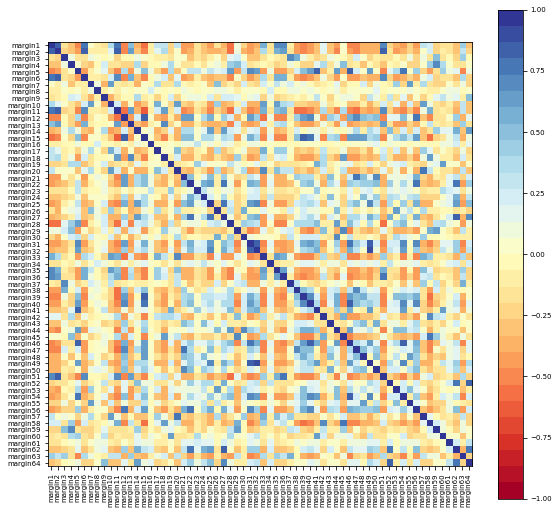

In [42]:
# correlation matrix for margin features
fig = plt.figure(figsize=(9.5,9))
ax = fig.add_subplot(1,1,1)
correlation_matrix(train[mColumns],ax)

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

# Obtain list of features
features = list(train)
del(features[:2]) # Delete id and species from features

# Apply PCA to our data
pca_result = pca.fit_transform(train[features].values)

# Define dataframe containing low-dimension representation of original data
pca_train = pd.DataFrame()
pca_train['species'] = train['species']
pca_train['pca-one'] = pca_result[:,0]
pca_train['pca-two'] = pca_result[:,1] 

# How much variance does this new representation retain from the original data?
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.14980004 0.101889   0.08671815]


## Data Preparation

In [63]:
train_ID = train['id']
test_ID = test['id']
le = LabelEncoder()
train_Y = train['species']
train_y = le.fit_transform(train_Y)

In [74]:
X = train.drop(['id','species'], axis = 1)
X_scaled = StandardScaler().fit_transform(X)

print(X_scaled.shape)

(990, 192)


In [64]:
y = to_categorical(train_y)
print(f"features shape {y.shape}.")

features shape (990, 99).


In [75]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model 1

In [79]:
model1 = Sequential()

model1.add(Dense(768,input_dim=192,  kernel_initializer='glorot_normal', activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(768, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(99, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 768)               148224    
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 99)                76131     
Total params: 814,947
Trainable params: 814,947
Non-trainable params: 0
_________________________________________________________________


In [82]:
start = time.time()
modelfit1 = model1.fit(X_train, y_train, epochs=30,validation_split=0.2)
end = time.time()
print("Training took {:.2f}s".format(end - start))

Epoch 1/30
20/20 [==============================] - 0s 15ms/step - loss: 1.0674 - accuracy: 0.7172 - val_loss: 1.1562 - val_accuracy: 0.6730
Epoch 2/30
20/20 [==============================] - 0s 12ms/step - loss: 0.9425 - accuracy: 0.7488 - val_loss: 1.0469 - val_accuracy: 0.7170
Epoch 3/30
20/20 [==============================] - 0s 12ms/step - loss: 0.8112 - accuracy: 0.7615 - val_loss: 0.9130 - val_accuracy: 0.7358
Epoch 4/30
20/20 [==============================] - 0s 13ms/step - loss: 0.7085 - accuracy: 0.8104 - val_loss: 0.8726 - val_accuracy: 0.7610
Epoch 5/30
20/20 [==============================] - 0s 13ms/step - loss: 0.6445 - accuracy: 0.8262 - val_loss: 0.7339 - val_accuracy: 0.7799
Epoch 6/30
20/20 [==============================] - 0s 12ms/step - loss: 0.5342 - accuracy: 0.8720 - val_loss: 0.6936 - val_accuracy: 0.8302
Epoch 7/30
20/20 [==============================] - 0s 12ms/step - loss: 0.4882 - accuracy: 0.8515 - val_loss: 0.6673 - val_accuracy: 0.8491
Epoch 8/30
20

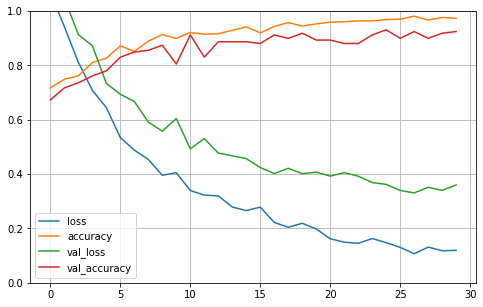

In [83]:
# Learning curves: the mean training loss and accuracy measured over each epoch, and the mean validation loss and 
# accuracy measured at the end of each epoch
pd.DataFrame(modelfit1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [84]:
model1.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.9293


[0.19286596775054932, 0.9292929172515869]

In [85]:
#create 1D array of y_test for validation
y_true = np.argmax(y_test, axis = 1)

In [86]:
y_pred1 = model1.predict(X_test)
y_pred1_classes = np.argmax(y_pred1, axis=1)

In [105]:
report = classification_report(y_true, y_pred1_classes, output_dict=True)
result1 = pd.DataFrame(report).transpose()
result1

C:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,4.000000
1,1.000000,1.000000,1.000000,1.000000
2,0.666667,1.000000,0.800000,2.000000
3,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,5.000000
...,...,...,...,...
97,1.000000,1.000000,1.000000,2.000000
98,1.000000,1.000000,1.000000,1.000000
accuracy,0.929293,0.929293,0.929293,0.929293
macro avg,0.904815,0.901111,0.892046,198.000000


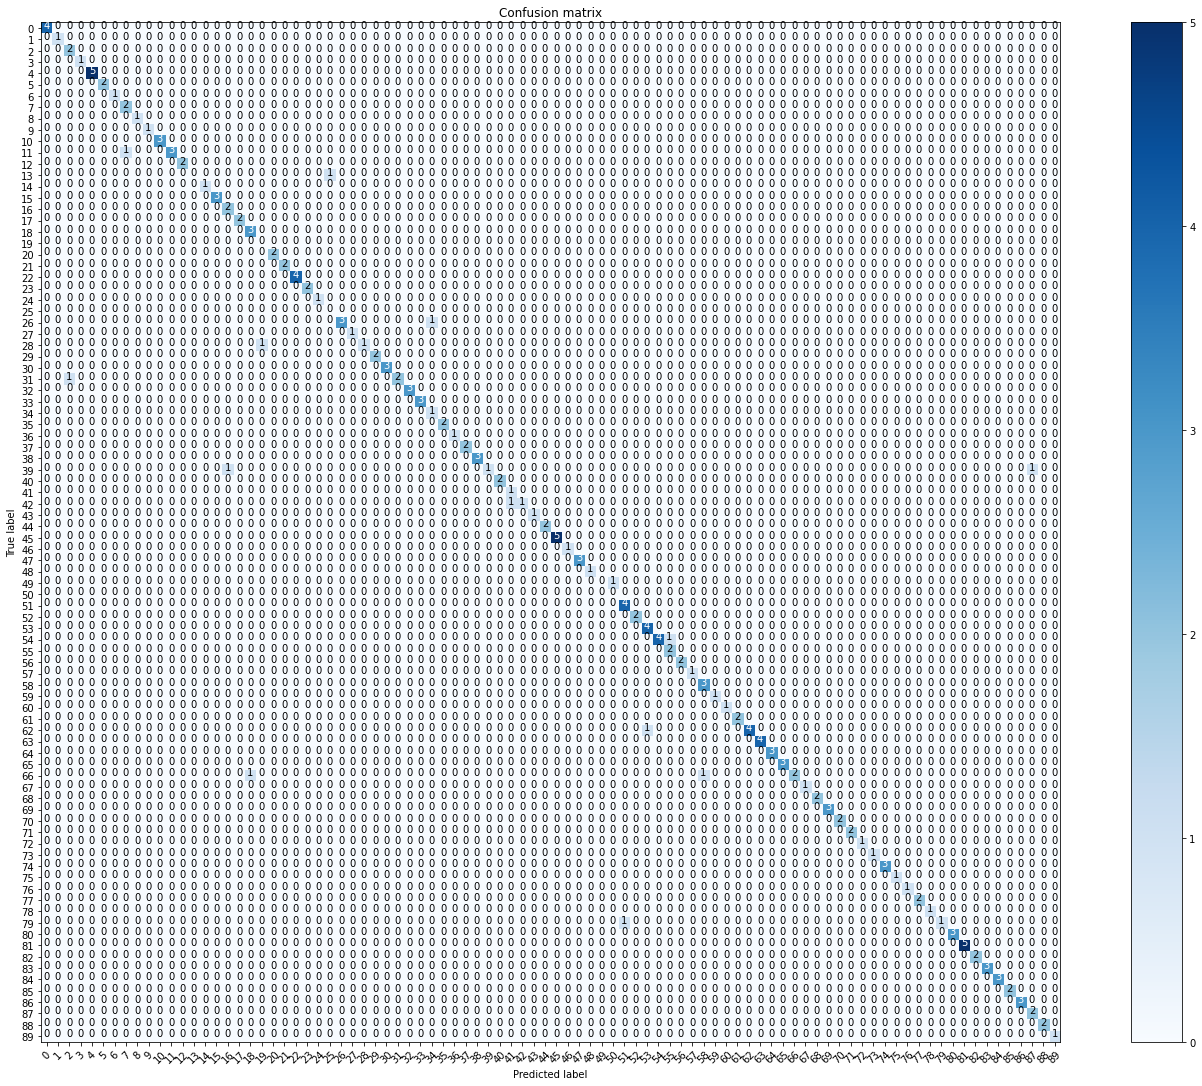

In [111]:
conf1 = confusion_matrix(y_true,y_pred1_classes)
plot_confusion_matrix(conf1,classes = range(90))

In [120]:
classes = X.describe().columns

In [149]:
y_train1 = np.argmax(y_test, axis = 1)
y_train1.shape

(198,)

In [151]:
y_pred_1 = np.argmax(y_pred1, axis = 1)
y_pred_1.shape

(198,)

ROC AUC score: 0.9657688035807328


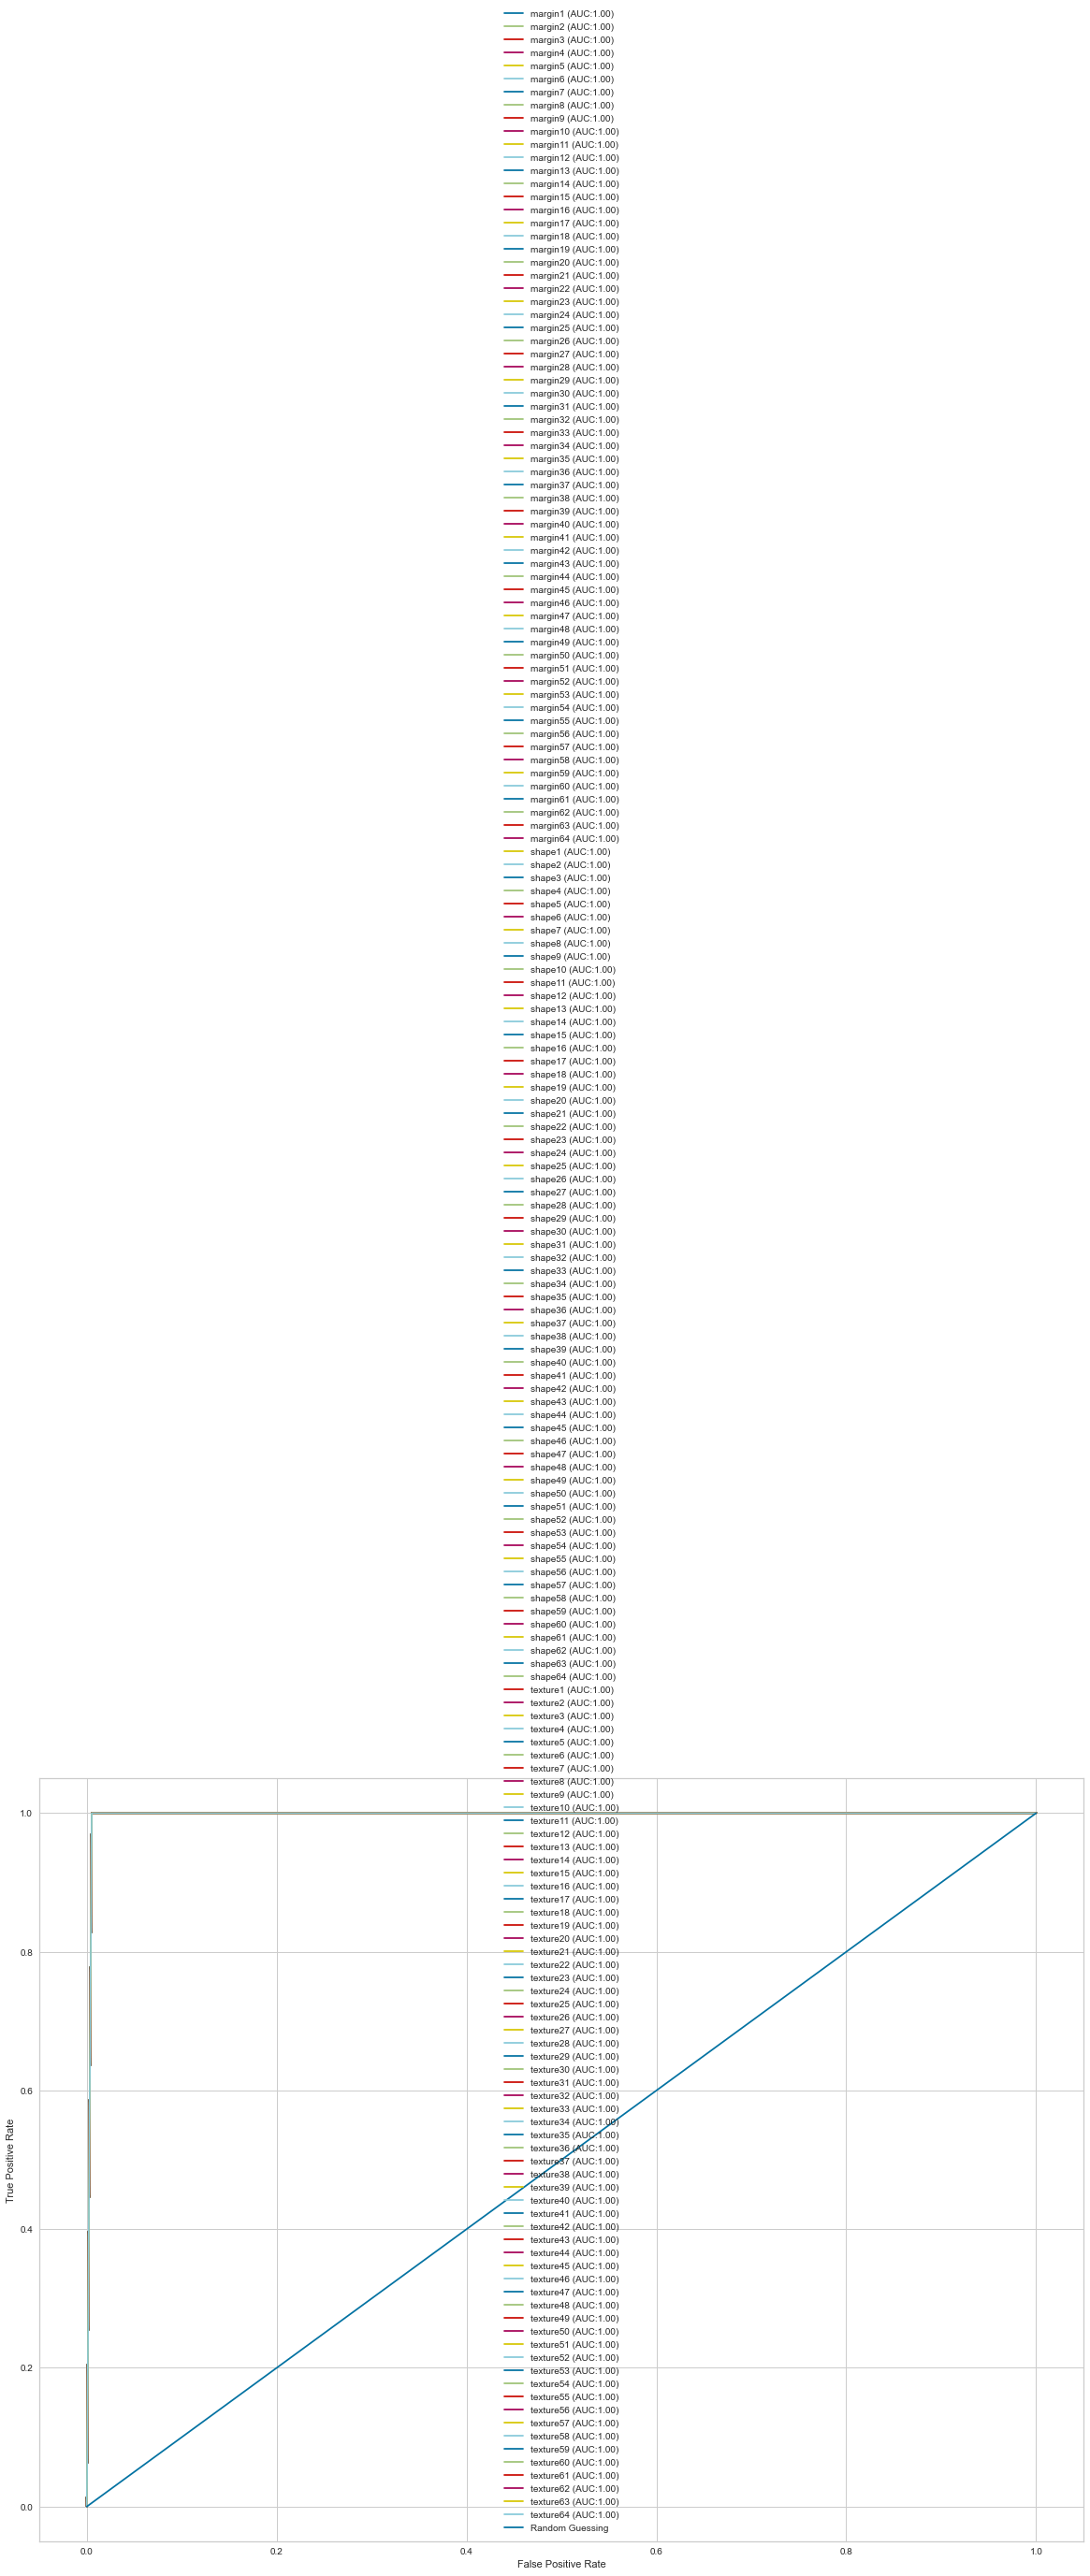

In [159]:
from sklearn.preprocessing import LabelBinarizer

target = classes

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (20, 15))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,50].astype(int), y_pred[:,50])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_train1, y_pred_1))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

## Hyperparameter Tuning

In [160]:
K.clear_session()

In [161]:
INPUT_SHAPE = X.shape[1:]
es = EarlyStopping(monitor='val_loss', patience=5)

In [179]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        
    def build(self, hp):    
        model = Sequential()
        model.add(Dense(768,input_dim=192,  kernel_initializer='glorot_normal', activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5,default=0.25,step=0.05)))
        model.add(Dense(units=hp.Int('units',min_value=32,max_value=512,step=32,default=512),activation=hp.Choice(
                    'dense_activation',values=['relu', 'tanh', 'sigmoid'],default='relu')))
        model.add(Dense(self.num_classes, activation='sigmoid'))

        model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate',min_value=1e-4,max_value=1e-2,sampling='LOG',
                    default=1e-3)),loss='categorical_crossentropy',metrics=['accuracy'])
        return model

In [184]:
hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=99)

In [185]:
tuner = Hyperband(
    hypermodel,
    max_epochs=30,
    objective='val_accuracy',
    seed=1,
    executions_per_trial=1,
    directory= os.path.normpath('C:/james/Desktop'))

INFO:tensorflow:Reloading Oracle from existing project C:\james\Desktop\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from C:\james\Desktop\untitled_project\tuner0.json


In [186]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
dropout_4 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units (Int)
{'default': 512, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_5 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (

In [187]:
tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Trial 44 Complete [00h 00m 09s]
val_accuracy: 0.9494949579238892

Best val_accuracy So Far: 0.9696969985961914
Total elapsed time: 00h 03m 43s
INFO:tensorflow:Oracle triggered exit


In [188]:
# Show a summary of the search
tuner.results_summary()

Results summary
Results in C:\james\Desktop\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_1: 0.1
num_filters: 64
dropout_2: 0.4
dropout_3: 0.30000000000000004
dropout_4: 0.2
units: 448
dense_activation: tanh
dropout_5: 0.45
learning_rate: 0.005198673201549641
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: d4561bf7ad3d044df73314875d374537
Score: 0.9696969985961914
Trial summary
Hyperparameters:
dropout_1: 0.1
num_filters: 64
dropout_2: 0.2
dropout_3: 0.05
dropout_4: 0.35000000000000003
units: 384
dense_activation: tanh
dropout_5: 0.15000000000000002
learning_rate: 0.0016839099393381122
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9696969985961914
Trial summary
Hyperparameters:
dropout_1: 0.4
num_filters: 32
dropout_2: 0.45
dropout_3: 0.45
dropout_4: 0.25
units: 416
dense_activation: tanh
dropout_5: 0.30000000000000004
learning_rat

## Model 2

In [189]:
# Retrieve the best model.
best_model = tuner.get_best_models()[0]

In [190]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 768)               148224    
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 448)               344512    
_________________________________________________________________
dense_2 (Dense)              (None, 99)                44451     
Total params: 537,187
Trainable params: 537,187
Non-trainable params: 0
_________________________________________________________________


In [191]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.1175 - accuracy: 0.9697


In [192]:
y_pred2 = best_model.predict(X_test)
y_pred2_classes = np.argmax(y_pred2, axis=1)

In [193]:
report2 = classification_report(y_true, y_pred2_classes, output_dict=True)
result2 = pd.DataFrame(report2).transpose()
result2

C:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,4.000000
1,1.000000,1.000000,1.000000,1.000000
2,0.666667,1.000000,0.800000,2.000000
3,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,5.000000
...,...,...,...,...
97,1.000000,1.000000,1.000000,2.000000
98,1.000000,1.000000,1.000000,1.000000
accuracy,0.969697,0.969697,0.969697,0.969697
macro avg,0.945644,0.947917,0.941703,198.000000


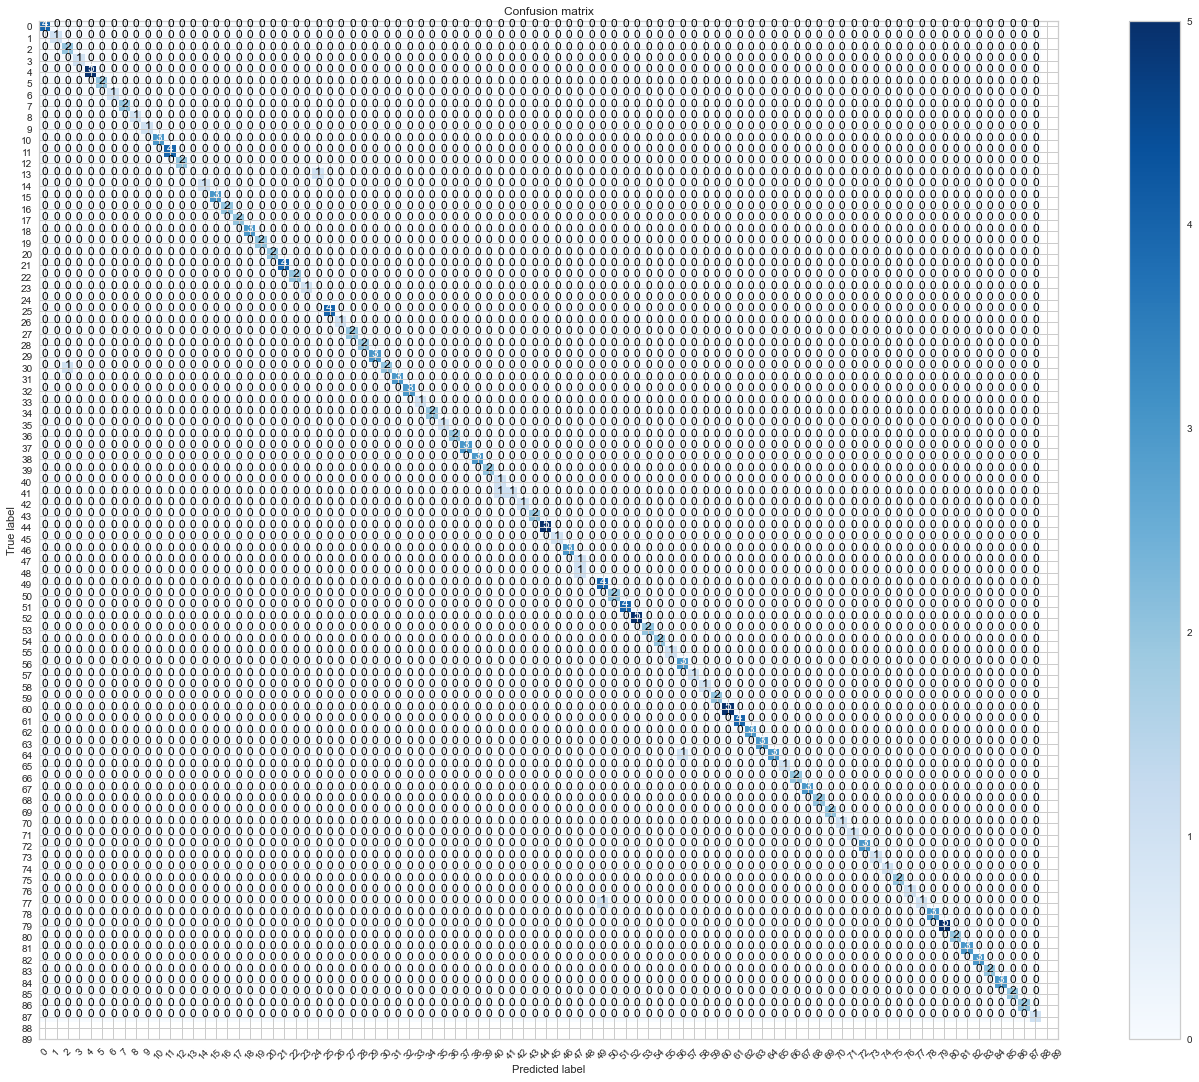

In [194]:
conf2 = confusion_matrix(y_true,y_pred2_classes)
plot_confusion_matrix(conf2,classes = range(90))

In [206]:
y_pred_2 = np.argmax(y_pred2, axis = 1)
print('ROC AUC score:', multiclass_roc_auc_score(y_train1, y_pred_2))

ROC AUC score: 0.9792593649269133


#### The hyper parameter search produced a better model. However it was not perfect. Therefore there may be a need to continue tuning the shape of the model instead.

## Model3

In [196]:
# Retrieve the 2nd best model from hyperparameter search.
best_model2 = best_model = tuner.get_best_models(num_models=3)[1]

In [197]:
best_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 768)               148224    
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 384)               295296    
_________________________________________________________________
dense_2 (Dense)              (None, 99)                38115     
Total params: 481,635
Trainable params: 481,635
Non-trainable params: 0
_________________________________________________________________


In [198]:
# Evaluate the best model.
loss, accuracy = best_model2.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.1854 - accuracy: 0.9697


#### The scoring between model 2 and model 3 is almost identical, although both sets have completely different parameter sets.

In [199]:
y_pred3 = best_model.predict(X_test)
y_pred3_classes = np.argmax(y_pred3, axis=1)

In [200]:
report3 = classification_report(y_true, y_pred3_classes, output_dict=True)
result3 = pd.DataFrame(report3).transpose()
result3

C:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,4.000000
1,1.000000,1.000000,1.000000,1.000000
2,0.666667,1.000000,0.800000,2.000000
3,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,5.000000
...,...,...,...,...
97,1.000000,1.000000,1.000000,2.000000
98,1.000000,1.000000,1.000000,1.000000
accuracy,0.969697,0.969697,0.969697,0.969697
macro avg,0.951326,0.954167,0.950180,198.000000


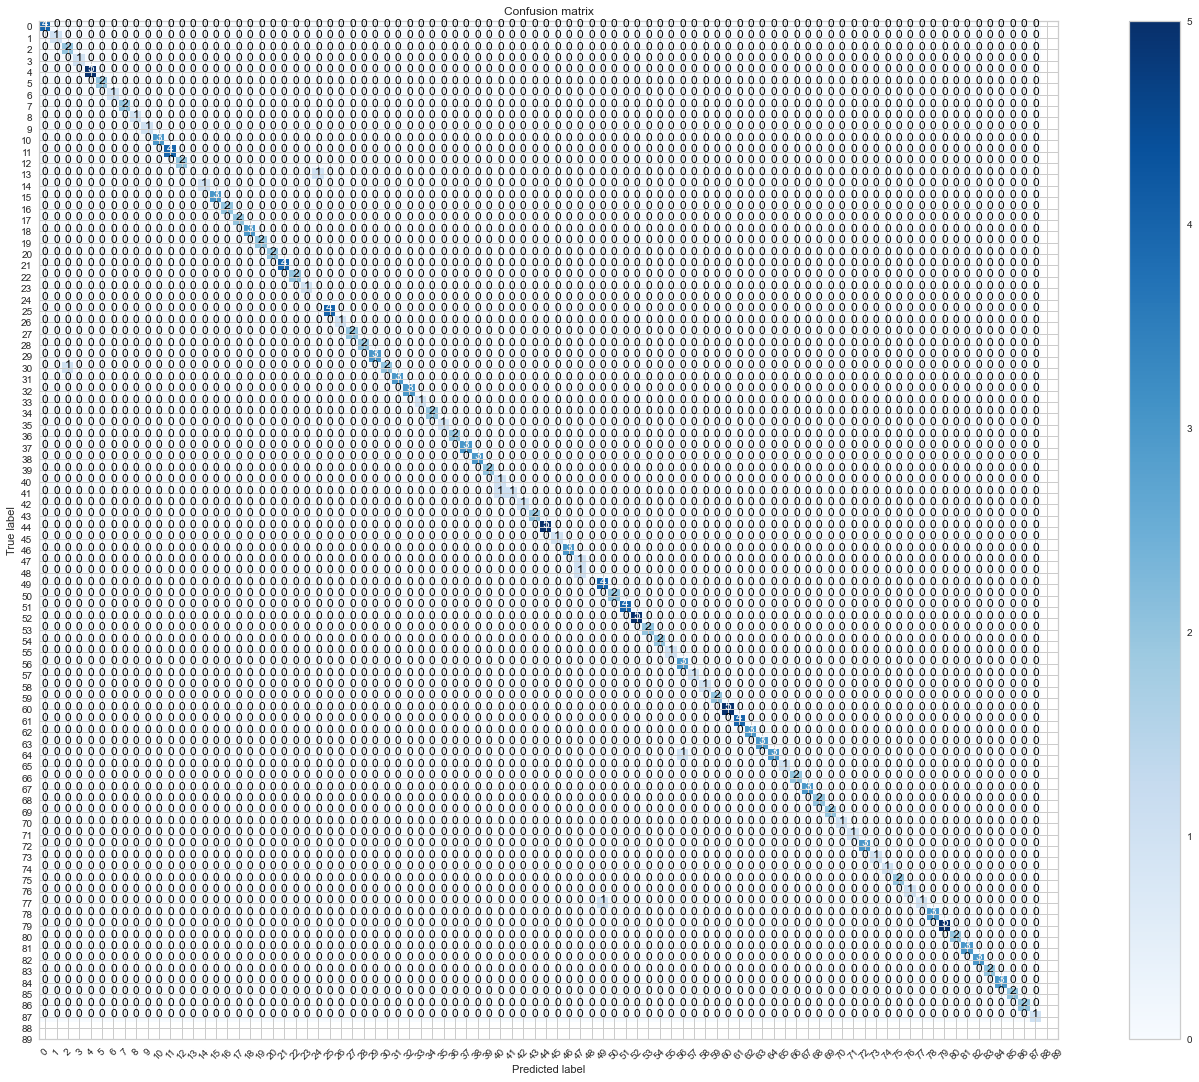

In [201]:
conf2 = confusion_matrix(y_true,y_pred2_classes)
plot_confusion_matrix(conf2,classes = range(90))

In [205]:
y_pred_3 = np.argmax(y_pred3, axis = 1)
print('ROC AUC score:', multiclass_roc_auc_score(y_train1, y_pred_3))

ROC AUC score: 0.9824494576977868


#### Model3 Produced a higher ROC score than model2 this is likely due to random occurances against the training set.